In [26]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
from scipy import stats
from magnificat.drw_dataset import DRWDataset
from magnificat.samplers.s82_sampler import S82Sampler
from magnificat.utils.split_utils import subsample_dist, random_split
from magnificat.utils.mag_noise import MagNoise, MagNoiseTorch
from torch.utils.data import DataLoader
import torch
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Instantiate S82 sampler

In [15]:
agn_params = ['BH_mass', 'redshift', 'M_i', 'u', 'g', 'r', 'i', 'z']
sampler = S82Sampler(agn_params=agn_params,
                     bp_params=['log_rf_tau', 'log_sf_inf'],
                     bandpasses=list('ugriz'),
                     out_dir='s82_sampler_dir',
                     seed=123)
sampler.process_metadata()

N_obs selection removed:  264
and left:  29116
Model likelihood selection removed:  1424
and left:  27692
Tau lower limit selection removed:  6136
and left:  21556
Edge selection removed:  0
and left:  21556
u 4660
g 4702
r 4354
i 4339
z 3501


## 2. Split train/val/test

Test ~ N(2.5, 0.1) in redshift

Train, val ~ remaining S82

We'll first subsample the test set.

In [16]:
high_z = stats.norm(loc=2.5, scale=0.1)
subsamples_i, kde_fit = subsample_dist(sampler.metadata['redshift'].values,
                                       high_z,
                                       n_samples=100,
                                       seed=123,
                                       return_kde_fit=True)

We need to ensure the KDE fit is reasonable, as the quality of fit affects the test set sampling.

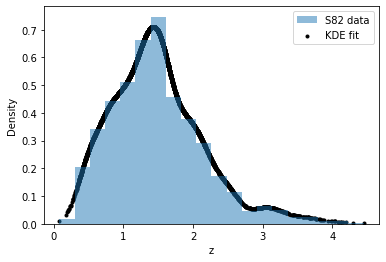

In [17]:
plt.close('all')
plt.hist(sampler.metadata['redshift'].values, bins=20, density=True, alpha=0.5, label='S82 data')
plt.scatter(sampler.metadata['redshift'].values, kde_fit.pdf(sampler.metadata['redshift'].values),
            color='k', marker='.', label='KDE fit')
plt.xlabel('z')
plt.ylabel('Density')
plt.legend()

We then split the remaining examples into train and val.

In [20]:
n_data = sampler.metadata.shape[0]
train_val_i = list(set(np.arange(n_data)) - set(subsamples_i))
train_i, val_i = random_split(train_val_i, frac_val=0.1, seed=123)

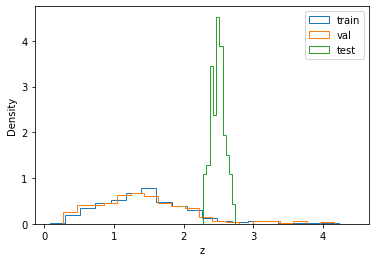

In [23]:
plt.close('all')
redshifts = sampler.metadata['redshift'].values
plt.hist(redshifts[train_i], bins=20, histtype='step', label='train', density=True)
plt.hist(redshifts[val_i], bins=20, histtype='step', label='val', density=True)
plt.hist(redshifts[subsamples_i], bins=10, histtype='step', label='test', density=True)
plt.xlabel('z')
plt.ylabel('Density')
plt.legend()

## 3. Instantiate DRWDataset with the S82 Sampler and photometric noise model

In [24]:
mag_noise_torch = MagNoiseTorch(mag_idx=[0, 1, 2, 3, 4],
                                which_bands=list('ugriz'),
                                override_kwargs=None,
                                depth=10,
                                airmass=1.15304)

In [28]:
# Now the sampler represents the training sampler only
sampler.idx = train_i
obs_kwargs = dict(n_pointings_init=3,
                  obs_dir='obs_testing',
                  bandpasses=list('ugriz'))
# DRWDataset with magnitude noise
drw_dataset = DRWDataset(sampler,
                         'drw_dataset_s82_noised',
                         num_samples=2,
                         is_training=True,
                         transform_x_func=lambda x: x,
                         transform_y_func=mag_noise_torch,
                         prestored_bandpasses=list('ugriz'),
                         seed=123,
                         obs_kwargs=obs_kwargs)

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 95.68it/s]


2 pointings were available.
Trimmed MJD has 593 out of 3650 days.


y, params: 100%|██████████████████████████████████| 2/2 [00:01<00:00,  1.18it/s]


In [29]:
data = drw_dataset[0]

In [43]:
data['x'].shape, data['y'].shape, data['trimmed_mask'].shape, drw_dataset.bandpasses

(torch.Size([593]),
 torch.Size([593, 5]),
 torch.Size([593, 5]),
 ['u', 'g', 'r', 'i', 'z'])

### Visualize light curve fully observed at trimmed LSST times

`trimmed LSST times` : times that were observed at least once in any filter for any pointing

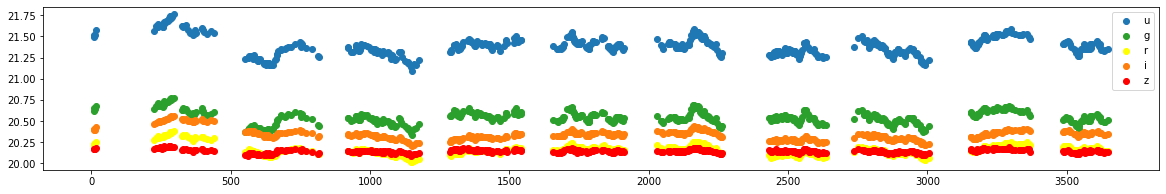

In [40]:
x = data['x'].cpu().numpy()
y = data['y'].cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 3))
bp_color = dict(zip(drw_dataset.bandpasses, ['r', 'tab:orange', 'yellow', 'tab:green', 'tab:blue'][::-1]))
for bp_i, bp in enumerate(drw_dataset.bandpasses):
    ax.scatter(x, y[:, bp_i], color=bp_color[bp], label=bp)
plt.legend()

### Visualize light curve only observed at LSST cadence

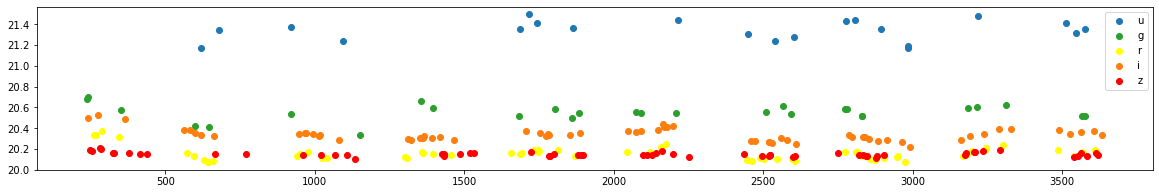

In [47]:
x = data['x'].cpu().numpy()
y = data['y'].cpu().numpy()
mask = data['trimmed_mask'].cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 3))
bp_color = dict(zip(drw_dataset.bandpasses, ['r', 'tab:orange', 'yellow', 'tab:green', 'tab:blue'][::-1]))
for bp_i, bp in enumerate(drw_dataset.bandpasses):
    ax.scatter(x[mask[:, bp_i]], y[:, bp_i][mask[:, bp_i]], color=bp_color[bp], label=bp)
plt.legend()